# Multiple -GPU
## Unet for multi-class segmentation
Train and predict

## Chalange description

The data is 3D MRI images with 4 channels:
* Flair
* T1
* T1ce
* T2

There are 259 photos in train data, each has segmentation labeling file, with the following lables:

* Label 0: background
* Label 1: necrotic and non-enhancing tumor
* Label 2: edema 
* Label 4: enhancing tumor

In the data preprocessing stage, I converted and merged the nii.gz files, to anumpy file of the format:
> (155, 240, 240, 4)
> For simplicity, I change label 4 to 3. So we need to change it back, for submitting results to Brats challange.

In [103]:
label_type_shrt = ['background', 'necrotic',
             'edema', 'enhancing']
label_type = ['background', 'necrotic and non-enhancing tumor', 'edema', 'enhancing tumor']

In [104]:
DATA= '/naomi/DATA/MICCAI_BraTS_2019_Data_Training/'
VALIDATION_DATA = '/naomi/DATA/MICCAI_BraTS_2019_Data_Validation/'
DATA_HGG = DATA +'HGG/'
DATA_LGG = DATA + 'LGG/'

NUMPY_DIR = '/naomi/DATA/MICCAI_BraTS_2019_Data_Training/numpy_images/'
VALIDATION_NUMPY_DIR = '/naomi/DATA/MICCAI_BraTS_2019_Data_Validation/numpy_images/'
FLAIR = 'flair'
T1 = 't1'
T2 = 't2'
T1CE = 't1ce'

In [105]:
img_type=['FLAIR', 'T1','T1CE', 'T2']

In [106]:
import os, sys, glob
import numpy as np
import SimpleITK as sitk
import sys
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
%matplotlib inline

In [107]:
import pandas
import numpy

In [108]:
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy import ndimage
import random
from random import randrange
from keras.utils import np_utils

## Visualization utilities

In [109]:

from importlib import reload  # Python 3.4+ only.
import visualization_utils  as vu
from visualization_utils import show_lable_on_image4
reload(vu)

<module 'visualization_utils' from '/naomi/visualization_utils.py'>

In [110]:
red_multiplier = [1, 0.2, 0.2]
green_multiplier = [0.35,0.75,0.25]
blue_multiplier = [0,0.5,1.] #[0,0.25,0.9]
yellow_multiplier = [1,1,0.25]
brown_miltiplier = [40./255, 26./255, 13./255]
my_colors=[blue_multiplier, yellow_multiplier, brown_miltiplier]

In [463]:
def show_img_lable(img, lbl, modality = 0):
    
    if (len(lbl.shape)> 2):
        lbl[0,0,3]=1 # for uniqe colors in plot
        lbl = lbl_from_cat(lbl)
    vu.show_n_images([img[:,:,modality],lbl, show_lable_on_image4(img[:,:,modality],lbl)],
                    titles = [img_type[modality], 'Label', 'Label on '+ img_type[modality]]);
    

In [464]:
def show_lable(lbl):
    
    
    vu.show_n_images([lbl[:,:,k] for k in range(4)]+[lbl_from_cat(lbl)],
                 titles = label_type_shrt + ['Label']) 

In [516]:
def show_pred_im_lable(im, lb, pred):
    lb[0,0]=1
    lb[0,1]=2
    lb[0,2]=3
    pred[0,0]=1
    pred[0,1]=2
    pred[0,2]=3
    vu.show_n_images([pred[:,:], lb[:,:], 
                   show_lable_on_image4(im[:,:,1], lb[:,:]),
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Prediction', 'Label', 'Label on T1', 'Prediction on Flair'])

In [509]:
def show_pred_im(im, pred):
    pred[0,0]=1
    pred[0,1]=2
    pred[0,2]=3    
    vu.show_n_images([im[:,:,1], 
                   im[:,:,0],pred,
                  show_lable_on_image4(im[:,:,1], pred[:,:])],
                 titles=['Flair','T1', 'Pred',  'Prediction on Flair'])

In [467]:
def print_info(imgs):
    for img in imgs:
        print('shape {} min {:.5} max {:3.5} mean: {:.5} std: {:.5}'.format(img.shape, float(img.min()), float(img.max()),float(img.mean()), img.std()))        

## Read image description files
In the preprocessing notebook, all files where saved as numpy.

Some statistics on the labels were collected, to assist the training phase.

In [266]:
df_train= pd.read_csv('df_train.csv')
df_test= pd.read_csv('df_test.csv')
df_val= pd.read_csv('df_val.csv')

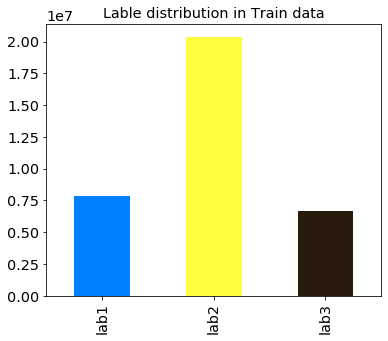

In [117]:
df_train[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution in Train data')

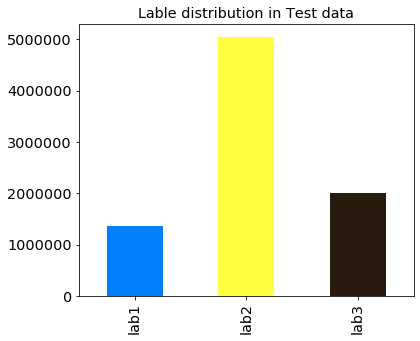

In [118]:
df_test[['lab' +str(i) for i in range(1,4)]].sum().plot(kind='bar', color=my_colors,
                                                   title='Lable distribution in Test data')

## Build Train generator

In [119]:
# Read numpy image file and label file
def get_numpy_img_lbl(img_id = 'BraTS19_TCIA10_449_1', np_dir=NUMPY_DIR):
    img=np.load(os.path.join(np_dir, img_id+'.npy'))
    lbl=np.load(os.path.join(np_dir, img_id+'_lbl.npy'))
    return img,lbl

In [120]:
# return random plane with non-zero label
def get_random_img(axis=0, df=df_train, np_dir=NUMPY_DIR):
    
    ind = randrange(len(df))
    img_id= df.iloc[ind].id
    img,lbl = get_numpy_img_lbl(img_id, np_dir=NUMPY_DIR)
        
    if (axis==0):
        x = randrange(df.iloc[ind].rmin, df.iloc[ind].rmax+1)
        return img[ x,:,:, :], lbl[x,:,:]

    im = np.zeros((240,240,4),dtype=np.float32)    
    lb = np.zeros((240,240),dtype=np.int)
        
    if (axis==1):
        y = randrange(df.iloc[ind].cmin, df.iloc[ind].cmax+1)
        im[40:40+155,:,:]=img[:, y,:, :]
        lb[40:40+155,:]=lbl[:, y,:]
        return im,lb
    
    if (axis == 2):
        z = randrange(df.iloc[ind].zmin, df.iloc[ind].zmax+1)
        im[40:40+155,:,:]=img[:,:, z, :]
        lb[40:40+155,:]=lbl[:,:,z]
        return im,lb
    return None    

<Figure size 432x360 with 0 Axes>

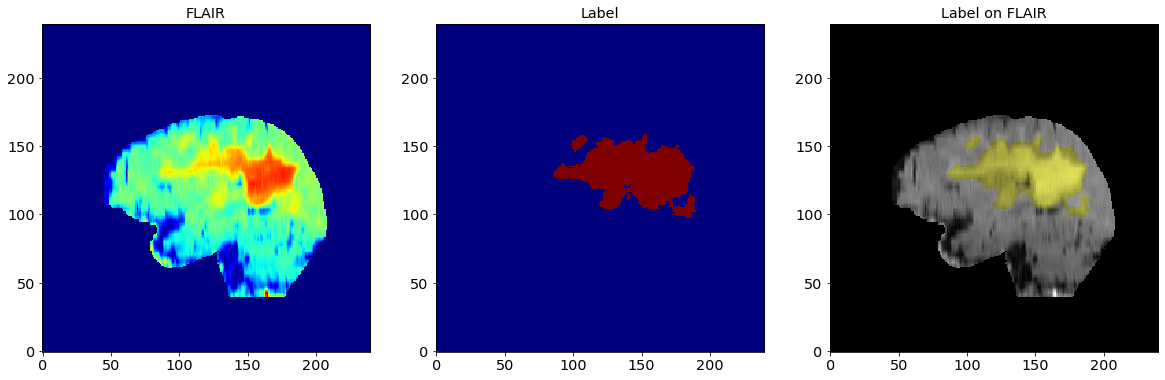

In [121]:
img,lbl = get_random_img(2)
show_img_lable(img, lbl)

Function randomly selects a 2D image that includes the given label

In [122]:
def get_img_for_label(lab=2, axis=0, df=df_train,np_dir = NUMPY_DIR):
    
    img_id= random.choice(df[df['lab'+str(lab)] > 0].id.values)
    
    img,lbl = get_numpy_img_lbl(img_id, np_dir)
    ind = np.where(lbl==lab)
    k = random.randrange(len(ind[0]))
    
    if (axis==0):        
        return img[ind[0][k],:,:] , lbl[ind[0][k],:,:]
        
    lb = np.zeros((240,240),dtype=np.int)
    im = np.zeros((240,240,4),dtype=np.float32)
    
    if (axis==1):
        im[40:40+155,:,:]=img[:, ind[1][k],:,:]
        lb[40:40+155,:]=lbl[:, ind[1][k],:]
        return im,lb
    
    if (axis == 2):
        im[40:40+155,:,:]=img[:, :, ind[2][k],:]
        lb[40:40+155,:]=lbl[:,:,ind[2][k]]
        return im,lb
    return None

<Figure size 432x360 with 0 Axes>

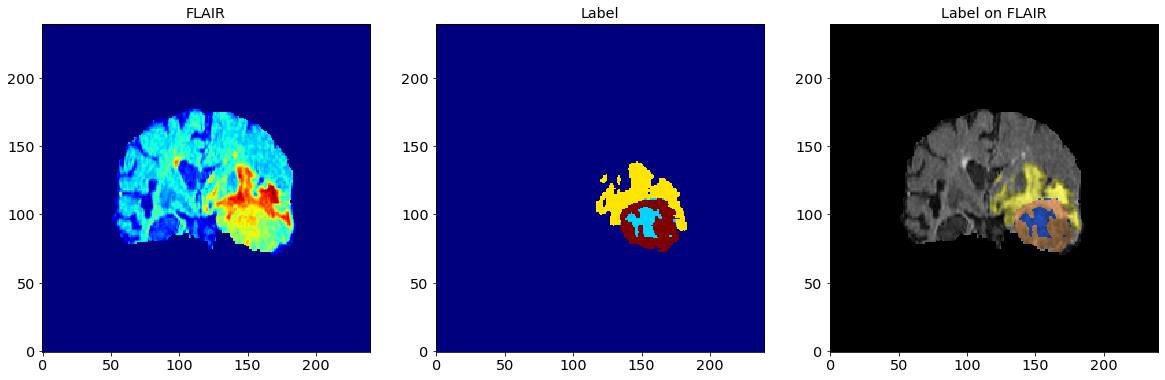

In [468]:
img,lbl = get_img_for_label(1,1)
show_img_lable(img, lbl)

In [469]:
np.unique(lbl)

array([0, 1, 2, 3])

<Figure size 432x360 with 0 Axes>

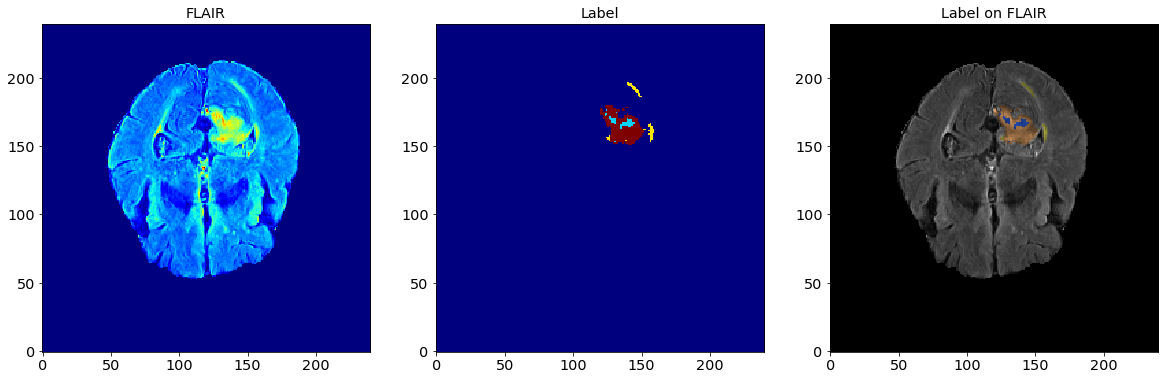

In [470]:
img,lbl = get_img_for_label(3,0)
show_img_lable(img, lbl)

In [231]:
lbl.shape

(240, 240)

<Figure size 432x360 with 0 Axes>

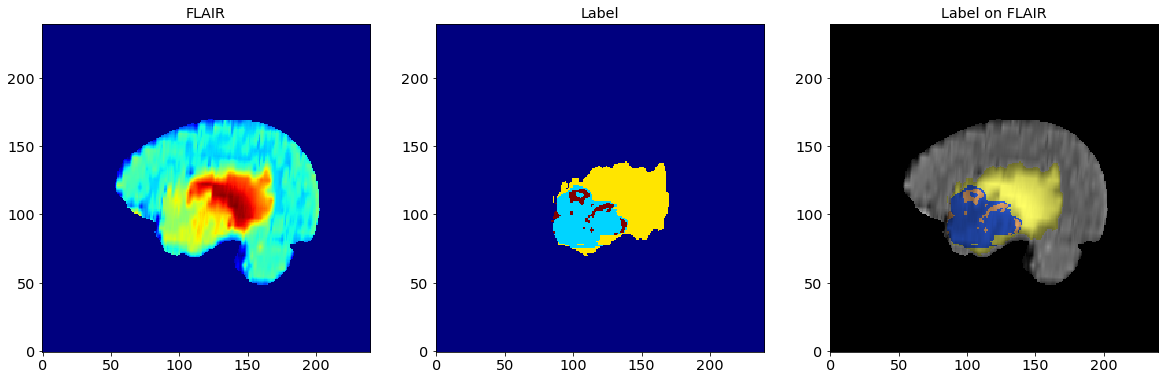

In [125]:
img,lbl = get_img_for_label(2,2)
show_img_lable(img, lbl)

<Figure size 432x360 with 0 Axes>

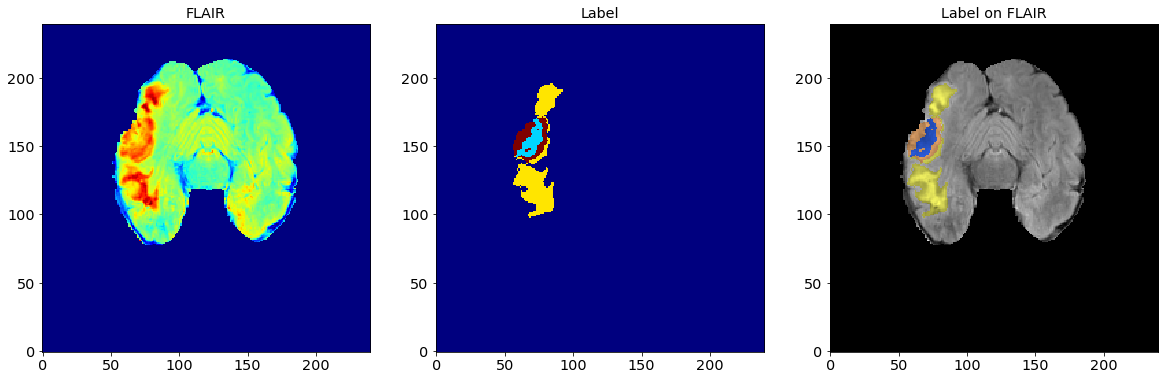

In [126]:
img,lbl = get_img_for_label(1,0)
show_img_lable(img, lbl)

In [127]:
# Return label from categorical
def lbl_from_cat(cat_lbl):
    
    lbl=0
    if (len(cat_lbl.shape)==3):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,i]*i
    elif (len(cat_lbl.shape)==4):
        for i in range(1,4):
            lbl = lbl + cat_lbl[:,:,:,i]*i
    else:
        print('Error in lbl_from_cat', cat_lbl.shape)
        return None
    return lbl

For test we will create batch from few test images. only planes with lables >0 will be included.

In [128]:
def normalize_3D_image(img):
    for z in range(img.shape[0]):
        img[z] = normalize_2D_image(img[z])
    return img

In [129]:
def normalize_2D_image(img):
    v_max = img.max(axis=(0, 1), keepdims=True)
    v_max = np.where(np.abs(v_max) <= 0.000001, 1., v_max)
 
    return (img)/(v_max)

Function returns all z-planes of the image that have non-zerolable

In [130]:
def get_img_batch(row, np_dir=NUMPY_DIR):
    
    im,lb = get_numpy_img_lbl(row['id'], np_dir)
    
    n_im = row['rmax']-row['rmin']
    rmin=row['rmin']
    rmax=row['rmax']
    
    return normalize_3D_image(im[rmin:rmax]), np_utils.to_categorical(lb[rmin:rmax],4)

<Figure size 432x360 with 0 Axes>

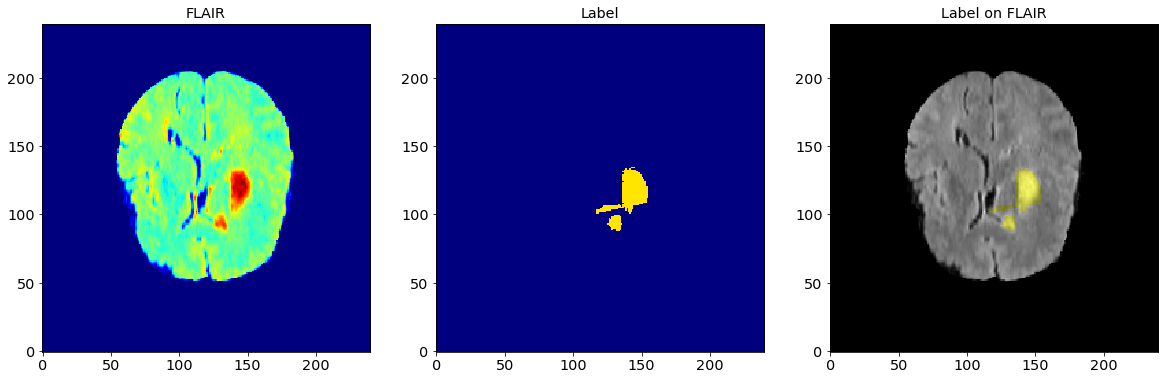

In [472]:
im, lb = get_img_batch(df_test.iloc[20])
im.shape, lb.shape
show_img_lable(im[6], lb[6])

<Figure size 432x360 with 0 Axes>

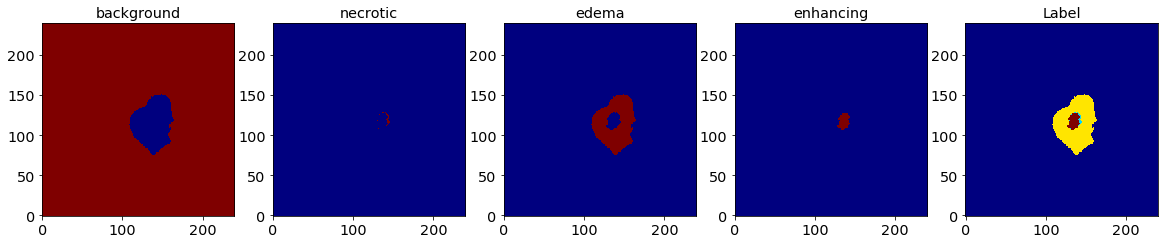

In [473]:
i=15
show_lable(lb[i])

<Figure size 432x360 with 0 Axes>

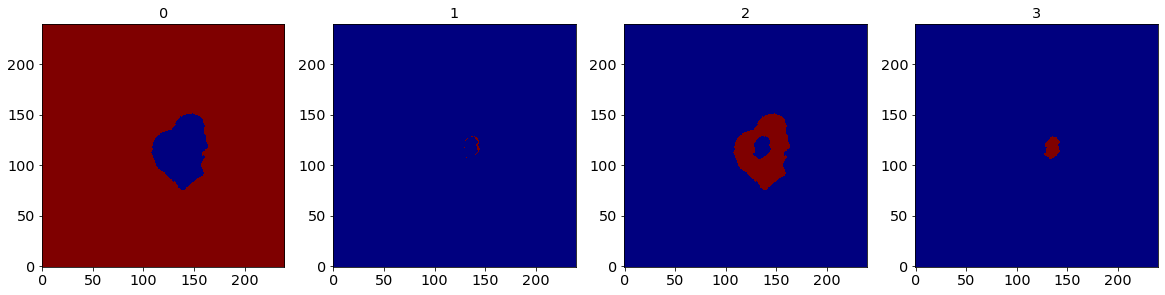

In [474]:
vu.show_n_images([lb[i, :,:,k] for k in range(4)], titles=[0,1,2,3])

Get images with non-zero labels from all raws of given data frame

In [133]:
def get_df_img_batch(df_batch, np_dir=NUMPY_DIR):
    
        n_images = (df_batch.rmax - df_batch.rmin).sum()
        b_images = np.zeros((n_images, 240, 240, 4), np.float32)
        b_label = np.zeros((n_images, 240, 240, 4), np.int8)    
        ind=0
        for index, row in df_batch.iterrows():
 
            b_im, b_lb = get_img_batch(row, np_dir)
            n_im = b_im.shape[0]
            b_images[ind:ind+n_im] = b_im
            b_label[ind:ind+n_im] = b_lb
            ind+=n_im
               
        return b_images, b_label

<Figure size 432x360 with 0 Axes>

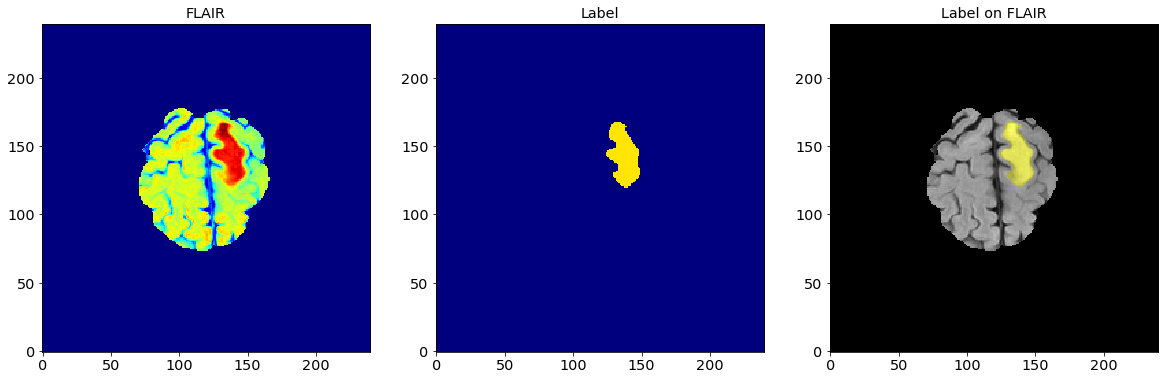

In [134]:
im, lb = get_df_img_batch(df_test.iloc[0:3])
show_img_lable(im[100],lb[100])

Generator for test images

Test the generator,takes
```
CPU times: user 640 ms, sys: 1.3 s, total: 1.94 s
Wall time: 2.72 s
```
3 images, ~251 planes

In [135]:
from keras.utils import np_utils
def generate_im_test_batch(n_images = 3, batch_size=300, df = df_test, np_dir=NUMPY_DIR):

    while 1:
         
        df_batch = df.sample(n_images)
        b_images, b_label = get_df_img_batch(df_batch, np_dir)                    
        b_images, b_label = shuffle(b_images, b_label)
        if (batch_size > 0):
            b_images = b_images[0:batch_size]
            b_label = b_label[0:batch_size]
            
        yield b_images, b_label

In [136]:
%%time
gen_test_im = generate_im_test_batch(5)#, 600)
imtest,lbtest = next(gen_test_im)
imtest.shape, lbtest.shape

CPU times: user 819 ms, sys: 1.47 s, total: 2.28 s
Wall time: 2.28 s


((300, 240, 240, 4), (300, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

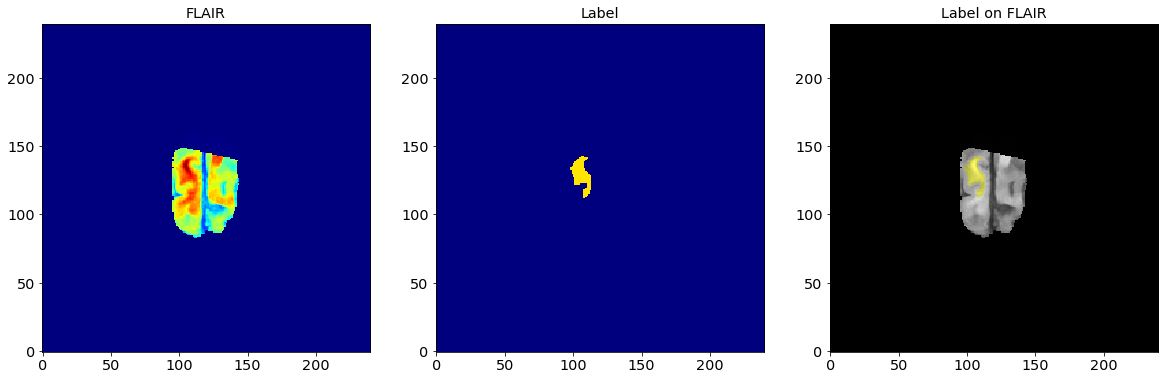

In [137]:
show_img_lable(imtest[100], lbtest[100])

<Figure size 432x360 with 0 Axes>

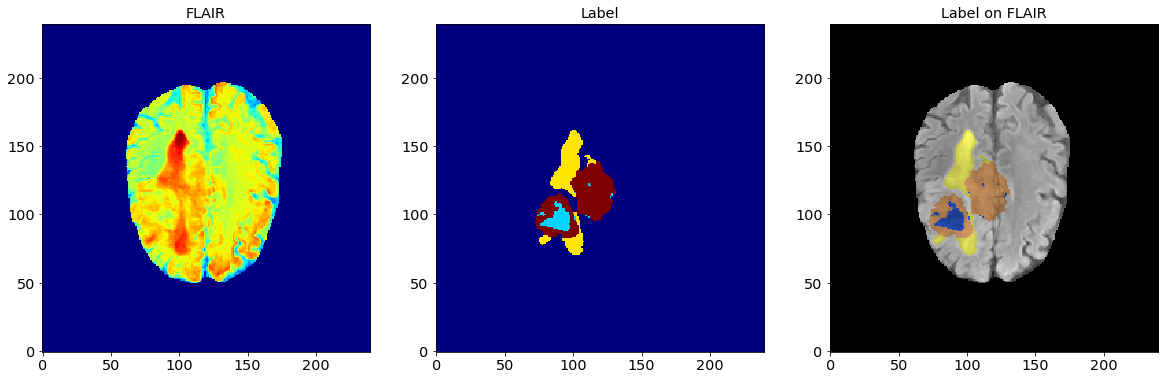

<Figure size 432x360 with 0 Axes>

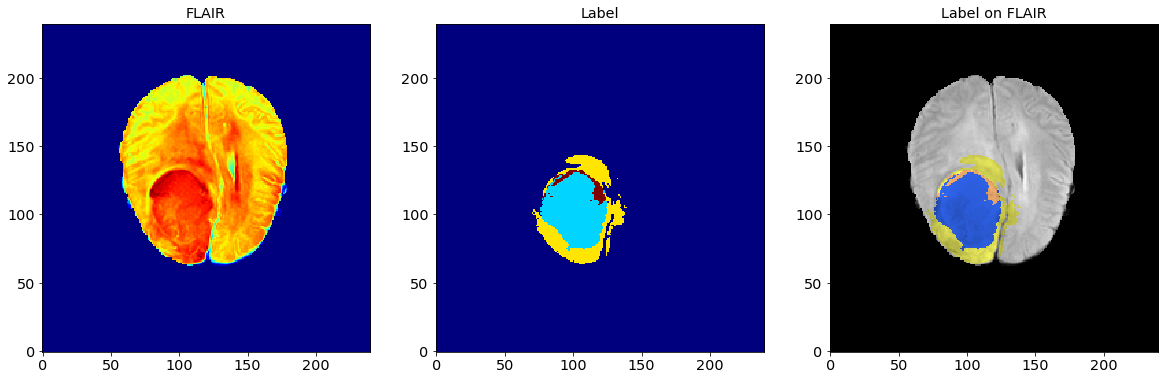

In [138]:
ind=[6,8]
for i in ind:show_img_lable(imtest[i], lbtest[i])

Test the faster generator. Takes:
```
CPU times: user 1.58 s, sys: 6.29 s, total: 7.87 s
Wall time: 12.4 s
```
for 32 batch size

## Augmentation

In [139]:
! pip install imgaug

You should consider upgrading via the 'pip install --upgrade pip' command.


In [140]:
import imageio
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage


### Rotate

In [141]:
def rot_2D_random(img, lbl):
    
    segmap = SegmentationMapsOnImage(lbl.astype(np.int8, copy=False), shape=lbl.shape)
    
    aug = iaa.Affine(rotate=(-90, 90))
    
    img,lbl_aug = aug(image=img, segmentation_maps=segmap)
   
    lbl = lbl_aug.get_arr()

    return img, lbl

In [383]:
def rot_2D_batch_random(imgages, lbl, rotate=(-45, 45)):
    
    for i in range(len(imgages)):
        imgages[i], lbl[i] = rot_2D_random(imgages[i], lbl[i])

    return imgages, lbl

In [384]:
i=8
rot_im, rot_la = rot_2D_random(imtest[i], lbtest[i])
rot_im.shape, rot_la.shape, imtest.shape, lbl_from_cat(lbtest).shape

((240, 240, 4), (240, 240, 4), (300, 240, 240, 4), (300, 240, 240))

<Figure size 432x360 with 0 Axes>

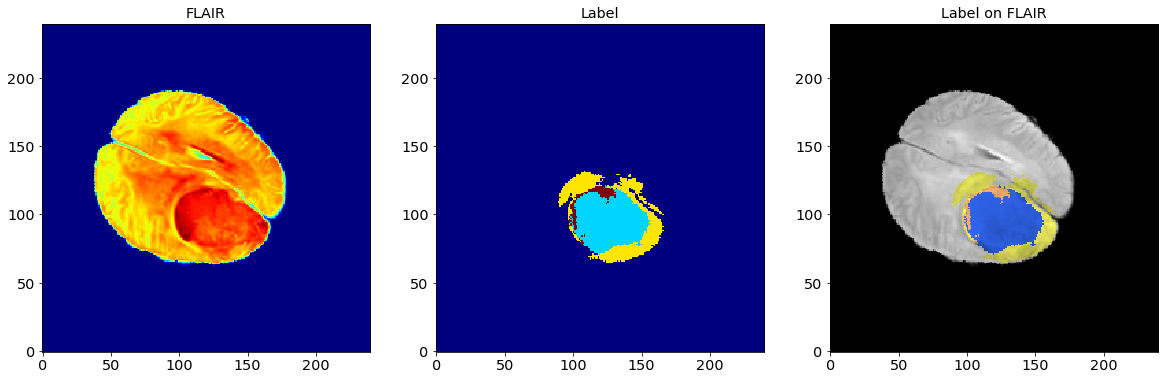

In [385]:
show_img_lable(rot_im, rot_la)

<Figure size 432x360 with 0 Axes>

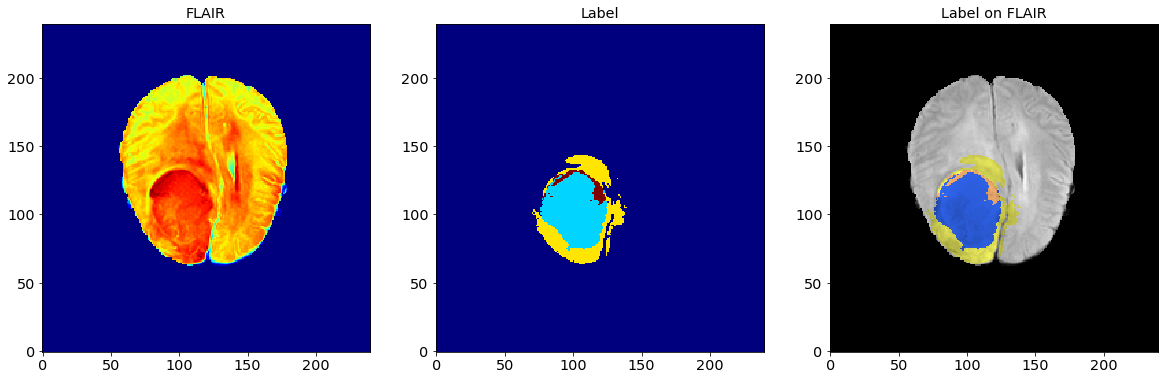

In [145]:
show_img_lable(imtest[i], lbtest[i])

<Figure size 432x360 with 0 Axes>

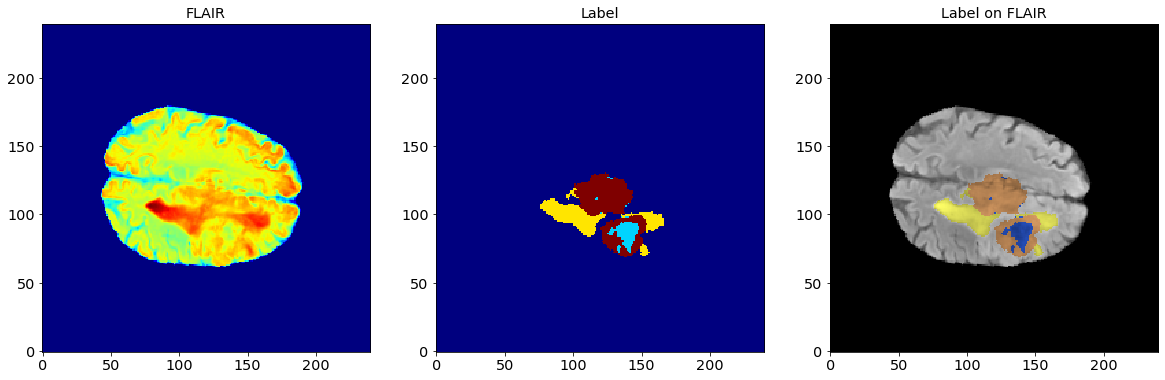

In [146]:
i=6
rot_im, rot_la = rot_2D_random(imtest[i], lbtest[i])
show_img_lable(rot_im, rot_la)

In [147]:
#### Flip

In [148]:
def random_flip_2D(bimg, blbl):
        
        aug = np.random.randint(1,5)
        
        if (aug==1):
            for j in range(4):
                bimg[:,:,j] = np.flipud(bimg[:,:,j])
            if (len(blbl.shape) == 2):
                blbl = np.flipud(blbl)
            else:
                for j in range(blbl.shape[2]):
                    blbl[:,:,j] = np.flipud(blbl[:,:,j])
            
        elif (aug==2):
            for j in range(4):
                bimg[:,:,j] = np.fliplr(bimg[:,:,j])
            if (len(blbl.shape) == 2):
                blbl = np.fliplr(blbl)
            else:
                for j in range(blbl.shape[2]):
                    blbl[:,:,j] = np.fliplr(blbl[:,:,j])

        elif (aug==3):
            for j in range(4):
                bimg[:,:,j] = np.rot90(bimg[:,:,j])
            if (len(blbl.shape) == 2):
                blbl = np.rot90(blbl)
            else:
                for j in range(blbl.shape[2]):
                    blbl[:,:,j] = np.rot90(blbl[:,:,j])

        return bimg, blbl    

<Figure size 432x360 with 0 Axes>

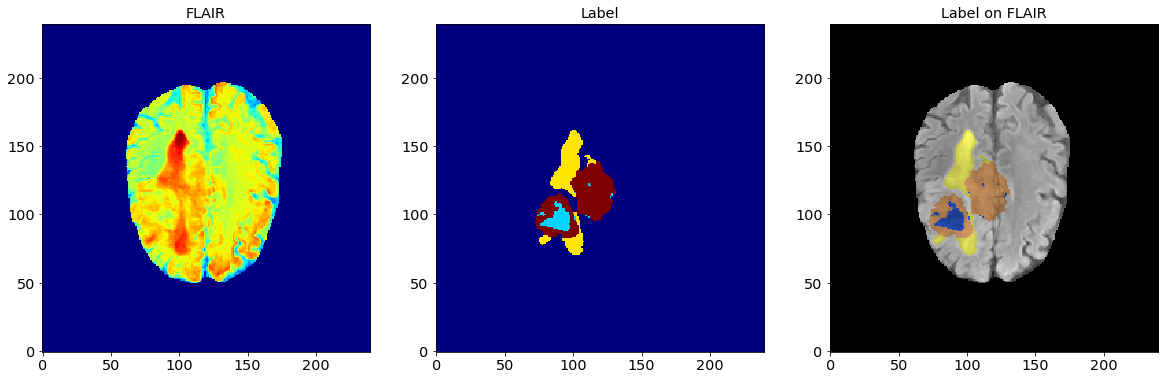

In [149]:
i=6
aug_im, aug_la = random_flip_2D(imtest[i], lbtest[i])
show_img_lable(aug_im, aug_la)

In [410]:
def aug_batch(imgages,lbl, n_aug):
    

    ind = np.random.choice(len(imgages), n_aug)
    for i in ind:
        imgages[i], lbl[i] = rot_2D_random(imgages[i], lbl[i])
        
    ind = np.random.choice(len(imgages), min(6*n_aug, len(imgages)-1))
    
    for i in ind:
        imgages[i], lbl[i] = random_flip_2D(imgages[i], lbl[i])
        imgages[i], lbl[i] = random_flip_2D(imgages[i], lbl[i])
    return imgages,lbl
    

## Train Batch Generator

In [411]:
#***

def generate_train_batch(batch_size = 12, df = df_train, n_aug=2):
    
    batch_images = np.zeros((batch_size, 240, 240, 4), np.float32)
    batch_label = np.zeros((batch_size, 240, 240, 1), np.int8)    
    
    # lab1 22%
    # lab2 58%
    # lab3 18%

    while 1:
         
        i = 0
        
        # lab 1
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=1, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i,:,:,0] = lbl
            i+=1
            
        
        # lab 2
        nim = batch_size//2
        for j in range(nim):
            im,lbl = get_img_for_label(lab=2, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i,:,:,0] = lbl
            i+=1
            
        # lab 3
        nim = batch_size//4
        for j in range(nim):
            im,lbl = get_img_for_label(lab=3, axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i,:,:,0] = lbl
            i+=1

        # The rest
        nim = batch_size - i
        for j in range(nim):
            im,lbl = get_random_img(axis=random.choice([0,1,2]), df=df)
            batch_images[i] = normalize_2D_image(im)
            batch_label[i,:,:,0] = lbl
            i+=1
                    
        batch_images, batch_label = shuffle(batch_images, batch_label)
        batch_images, batch_label = aug_batch(batch_images, batch_label, n_aug)    
        yield batch_images, np_utils.to_categorical(batch_label, 4)

In [388]:
%%time
gen_train = generate_train_batch(batch_size=36)
bimg,blbl = next(gen_train)
bimg.shape, blbl.shape

CPU times: user 1.42 s, sys: 6.82 s, total: 8.24 s
Wall time: 8.22 s


((36, 240, 240, 4), (36, 240, 240, 4))

#### old server
CPU times: user 2.76 s, sys: 12.6 s, total: 15.3 s
Wall time: 22 s
((36, 240, 240, 4), (36, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

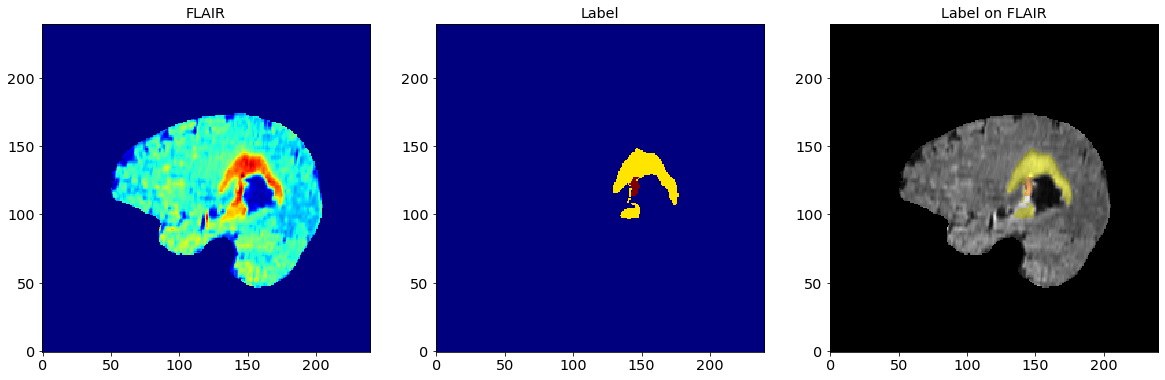

In [389]:
i=12
show_img_lable(bimg[i], blbl[i])

Test the generator old server
```
CPU times: user 2.53 s, sys: 12.4 s, total: 14.9 s
Wall time: 24.7 s
```

DGX
```
CPU times: user 1.24 s, sys: 6.63 s, total: 7.87 s
Wall time: 7.87 s
```

In [156]:
%%time
gen_test = generate_train_batch(36,df_test)
bimg,blbl = next(gen_test)
bimg.shape, blbl.shape

CPU times: user 1.39 s, sys: 7.56 s, total: 8.95 s
Wall time: 8.92 s


((36, 240, 240, 4), (36, 240, 240, 4))

<Figure size 432x360 with 0 Axes>

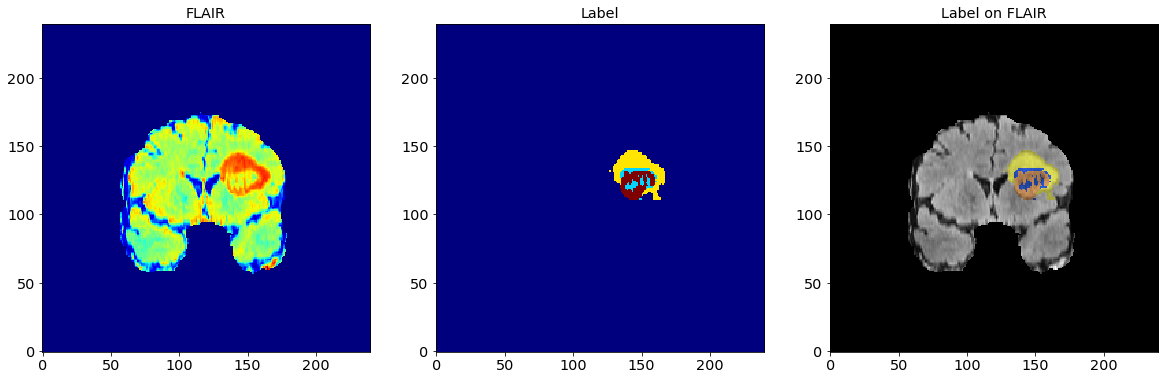

In [157]:
i=6
show_img_lable(bimg[i], blbl[i])

## define Base Unet Model

In [164]:
import tensorflow as tf
from keras import backend as K

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import Input, UpSampling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [165]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_CHANNELS = 4

In [166]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [167]:
import model_unet
reload(model_unet)

<module 'model_unet' from '/naomi/model_unet.py'>

In [168]:
from keras.utils import multi_gpu_model

# Instantiate the base model (or "template" model).
# We recommend doing this with under a CPU device scope,
# so that the model's weights are hosted on CPU memory.
# Otherwise they may end up hosted on a GPU, which would
# complicate weight sharing.
with tf.device('/cpu:0'):
    model = model_unet.unet(input_size = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

# Replicates the model on 8 GPUs.
# This assumes that your machine has 8 available GPUs.
parallel_model = multi_gpu_model(model, gpus=8)
parallel_model.compile(loss='categorical_crossentropy',
                       optimizer = Adam(lr = 0.0001),
                      metrics=['accuracy'])

### One GPU version
```
import model_unet

model = model_unet.unet(input_size = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
```

In [48]:
#model.summary()

In [65]:

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_2.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

log_dir="logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
gen_test_im

In [ ]:
parallel_model.load_weights()

In [52]:
%%time
history = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        validation_data =( bimg,blbl), 
                              #validation_data =gen_test_im, validation_steps=2,
                                          
                              epochs=10,
                    callbacks=[earlystopper, checkpointer])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
20/20 [==============================] - 165s 8s/step - loss: 0.4313 - val_loss: 0.1245

Epoch 00001: val_loss improved from inf to 0.12446, saving model to model_unet_4ch.hdf5
Epoch 2/10
20/20 [==============================] - 158s 8s/step - loss: 0.1156 - val_loss: 0.0965

Epoch 00002: val_loss improved from 0.12446 to 0.09652, saving model to model_unet_4ch.hdf5
Epoch 3/10
20/20 [==============================] - 159s 8s/step - loss: 0.0924 - val_loss: 0.0826

Epoch 00003: val_loss improved from 0.09652 to 0.08256, saving model to model_unet_4ch.hdf5
Epoch 4/10
20/20 [==============================] - 158s 8s/step - loss: 0.0864 - val_loss: 0.0759

Epoch 00004: val_loss improved from 0.08256 to 0.07590, saving model to model_unet_4ch.hdf5
Epoch 5/10
20/20 [==============================] - 160s 8s/step - loss: 0.0793 - val_loss: 0.0606

Epoch 00005: val_loss improved from 0.075

In [ ]:
Old server time
```
CPU times: user 21.5 s, sys: 1min 32s, total: 1min 53s
Wall time: 2min 29s
```

DGX with multiple model, first version
```
CPU times: user 12min 13s, sys: 23min 22s, total: 35min 36s
Wall time: 26min 42s
```

dict_keys(['val_loss', 'loss'])


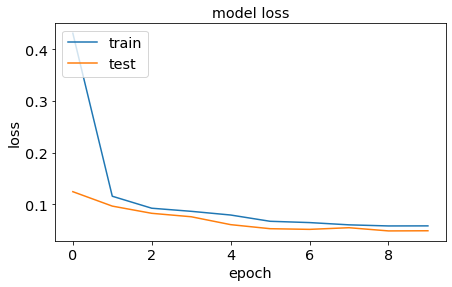

In [53]:
vu.drow_history(history)

In [ ]:
model.save_weights('model_unet_ce.hdf5')

In [ ]:
model.load_weights('model_unet_4ch.hdf5')

In [ ]:
gen_test_im

In [66]:
parallel_model.load_weights('model_unet_4ch.hdf5')

In [67]:
%%time
history2 = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        validation_data =( imtest,lbtest), 
                              #validation_data =gen_test_im, validation_steps=2,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
20/20 [==============================] - 175s 9s/step - loss: 0.1225 - accuracy: 0.9645 - val_loss: 0.0458 - val_accuracy: 0.9848

Epoch 00001: val_loss improved from inf to 0.04576, saving model to model_unet_4ch_2.hdf5
Epoch 2/100
20/20 [==============================] - 169s 8s/step - loss: 0.0723 - accuracy: 0.9759 - val_loss: 0.0348 - val_accuracy: 0.9891

Epoch 00002: val_loss improved from 0.04576 to 0.03477, saving model to model_unet_4ch_2.hdf5
Epoch 3/100
20/20 [==============================] - 170s 9s/step - loss: 0.0757 - accuracy: 0.9759 - val_loss: 0.0602 - val_accuracy: 0.9866

Epoch 00003: val_loss did not improve from 0.03477
Epoch 4/100
20/20 [==============================] - 171s 9s/step - loss: 0.0560 - accuracy: 0.9806 - val_loss: 0.0346 - val_accuracy: 0.9901

Epoch 00004: val_loss improved from 0.03477 to 0.03459, saving model to model_unet_4ch_2.hdf5
Epoc

Epoch 38/100
20/20 [==============================] - 171s 9s/step - loss: 0.0336 - accuracy: 0.9876 - val_loss: 0.0215 - val_accuracy: 0.9928

Epoch 00038: val_loss did not improve from 0.01849
Epoch 39/100
20/20 [==============================] - 172s 9s/step - loss: 0.0318 - accuracy: 0.9881 - val_loss: 0.0227 - val_accuracy: 0.9919

Epoch 00039: val_loss did not improve from 0.01849
Epoch 40/100
20/20 [==============================] - 171s 9s/step - loss: 0.0315 - accuracy: 0.9884 - val_loss: 0.0182 - val_accuracy: 0.9935

Epoch 00040: val_loss improved from 0.01849 to 0.01822, saving model to model_unet_4ch_2.hdf5
Epoch 41/100
20/20 [==============================] - 172s 9s/step - loss: 0.0280 - accuracy: 0.9897 - val_loss: 0.0184 - val_accuracy: 0.9935

Epoch 00041: val_loss did not improve from 0.01822
Epoch 42/100
20/20 [==============================] - 172s 9s/step - loss: 0.0312 - accuracy: 0.9883 - val_loss: 0.0172 - val_accuracy: 0.9938

Epoch 00042: val_loss improved fr

In [70]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_3.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_3.hdf5',
                               verbose=1, monitor='val_accuracy',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [169]:
parallel_model.compile(loss='categorical_crossentropy',
                       optimizer = Adam(lr = 0.00001),
                      metrics=['accuracy'])

In [73]:
parallel_model.load_weights('model_unet_4ch_2.hdf5')

In [74]:
%%time
history3 = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=2,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 180s 9s/step - loss: 0.0350 - accuracy: 0.9899 - val_loss: 0.0161 - val_accuracy: 0.9943

Epoch 00001: val_loss improved from inf to 0.01614, saving model to model_unet_4ch_3.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.99432, saving model to model_unet_best_acc_4ch_3.hdf5
Epoch 2/100
20/20 [==============================] - 173s 9s/step - loss: 0.0257 - accuracy: 0.9904 - val_loss: 0.0301 - val_accuracy: 0.9903

Epoch 00002: val_loss did not improve from 0.01614

Epoch 00002: val_accuracy did not improve from 0.99432
Epoch 3/100
20/20 [==============================] - 175s 9s/step - loss: 0.0233 - accuracy: 0.9912 - val_loss: 0.0104 - val_accuracy: 0.9946

Epoch 00003: val_loss improved from 0.01614 to 0.01038, saving model to model_unet_4ch_3.hdf5

Epoch 00003: val_accuracy improved from 0.99432 to 0.99456, saving model to model_unet_best_acc_4ch_3.hdf5
Epoch 4/100
20/20 [==============================] - 174s 9s/step -

In [170]:
parallel_model.load_weights('model_unet_4ch_3.hdf5')

In [188]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_dice.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_dice.hdf5',
                               verbose=1, monitor='val_accuracy',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [174]:
parallel_model.compile(loss=dice_coef_loss,
                       optimizer = Adam(lr = 0.0001),
                      metrics=['accuracy', 'categorical_crossentropy'])

In [175]:
%%time
history4 = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=2,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 185s 9s/step - loss: -0.9841 - accuracy: 0.9849 - categorical_crossentropy: 0.0826 - val_loss: -0.9874 - val_accuracy: 0.9903 - val_categorical_crossentropy: 0.0341

Epoch 00001: val_loss improved from inf to -0.98745, saving model to model_unet_4ch_dice.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.99033, saving model to model_unet_best_acc_4ch_dice.hdf5
Epoch 2/100
20/20 [==============================] - 176s 9s/step - loss: -0.9875 - accuracy: 0.9881 - categorical_crossentropy: 0.0601 - val_loss: -0.9928 - val_accuracy: 0.9936 - val_categorical_crossentropy: 0.0276

Epoch 00002: val_loss improved from -0.98745 to -0.99280, saving model to model_unet_4ch_dice.hdf5

Epoch 00002: val_accuracy improved from 0.99033 to 0.99356, saving model to model_unet_best_acc_4ch_dice.hdf5
Epoch 3/100
20/20 [==============================] - 176s 9s/step - loss: -0.9886 - accuracy: 0.9891 - categorical_crossentropy: 0.0568 - val_loss: -0

## Loss functions

In [280]:
from keras import backend as K
from keras.layers import Input, MaxPooling2D, UpSampling2D, Conv2D
from keras.layers import concatenate
from keras.models import Model
from keras.optimizers import Adam

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [285]:
def dice_coef4(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,1:4])
    y_pred_f = K.flatten(y_pred[:,:,:,1:4])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss4(y_true, y_pred):
    return -dice_coef4(y_true, y_pred)

In [286]:
def logit_categorical_crossentropy(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred, from_logits=True)

In [292]:
def logit_categorical_crossentropy4(y_true, y_pred):
    return K.categorical_crossentropy(y_true[:,:,:,1:4], y_pred[:,:,:,1:4], from_logits=True)

In [293]:
def categorical_crossentropy4(y_true, y_pred):
    return K.categorical_crossentropy(y_true[:,:,:,1:4], y_pred[:,:,:,1:4])

In [304]:
import keras
def accuracy4(y_true, y_pred):
    return keras.metrics.accuracy(y_true[:,:,:,1:4], y_pred[:,:,:,1:4])

In [298]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [427]:
def jaccard_distance_loss4(y_true, y_pred, smooth=100):

    intersection = K.sum(K.abs(y_true[:,:,:,1:4] * y_pred[:,:,:,1:4]), axis=-1)
    sum_ = K.sum(K.abs(y_true[:,:,:,1:4]) + K.abs(y_pred[:,:,:,1:4]), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [475]:
def jac_dice4(y_true, y_pred):
    
    return jaccard_distance_loss4(y_true, y_pred) - 1. -dice_coef4(y_true, y_pred)-dice_coef(y_true, y_pred)*0.5

In [476]:
def jac_dice_cross4(y_true, y_pred):
    
    return jac_dice4(y_true, y_pred)-(1.-logit_categorical_crossentropy4(y_true, y_pred))-dice_coef(y_true, y_pred)*0.5

### Enlarge Train group

In [267]:
df_test.shape, df_train.shape

((88, 12), (348, 12))

In [268]:
df_test.head()

,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
0,LGG,BraTS19_TCIA10_640_1,8897677,7040,22743,540,91,129,100,155,127,173
1,HGG,BraTS19_TCIA01_131_1,8890172,3169,25665,8994,53,129,99,167,120,154
2,HGG,BraTS19_CBICA_AQJ_1,8840391,6619,58882,22108,55,136,95,201,100,163
3,HGG,BraTS19_TCIA02_331_1,8861184,736,48139,17941,38,122,137,208,119,168
4,HGG,BraTS19_TCIA08_234_1,8845977,1523,69570,10930,48,116,116,181,56,109


In [274]:
df_test=df_test.sort_values(['lab1','lab3']).reset_index()
df_test.tail()

,level_0,index,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
83,83,64,HGG,BraTS19_TCIA05_478_1,8727379,52012,83517,65092,60,129,50,150,62,140
84,84,8,HGG,BraTS19_TCIA01_180_1,8781506,53224,76326,16944,55,136,61,144,67,139
85,85,10,HGG,BraTS19_2013_21_1,8807326,57655,45203,17816,60,132,86,157,118,180
86,86,33,LGG,BraTS19_TCIA10_241_1,8765895,72158,72771,17176,32,96,85,180,112,182
87,87,32,LGG,BraTS19_TCIA10_261_1,8725573,146041,49316,7070,58,133,50,148,54,145


In [275]:
df_test2 = df_test.iloc[44:].copy()
df_test2['Grade'].value_counts()

HGG    40
LGG     4
Name: Grade, dtype: int64

In [276]:
df_train['Grade'].value_counts()

HGG    280
LGG     68
Name: Grade, dtype: int64

In [278]:
df_train2 = pd.concat([df_train, df_test.iloc[0:44].copy()], axis=1)
df_train2.head()

,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,...,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
0,HGG,BraTS19_CBICA_ASG_1,8795318,30245,70436,32001,46,137,55,130,...,8920487.0,0.0,6275.0,1238.0,44.0,66.0,113.0,177.0,130.0,165.0
1,HGG,BraTS19_CBICA_ABO_1,8744906,25359,106834,50901,30,110,84,207,...,8893541.0,115.0,33068.0,1276.0,58.0,106.0,53.0,117.0,139.0,177.0
2,LGG,BraTS19_TCIA10_299_1,8881564,148,35008,11280,80,136,127,182,...,8888763.0,135.0,38411.0,691.0,59.0,108.0,90.0,138.0,137.0,180.0
3,HGG,BraTS19_CBICA_AQV_1,8876147,6192,32835,12826,58,109,122,175,...,8884432.0,156.0,37208.0,6204.0,37.0,88.0,135.0,191.0,139.0,183.0
4,HGG,BraTS19_2013_2_1,8866915,4514,34894,21677,69,126,80,175,...,8915048.0,204.0,11711.0,1037.0,40.0,71.0,138.0,176.0,79.0,111.0


In [390]:
df_test=df_test2
df_train=df_train2

In [391]:
parallel_model.compile(loss=dice_coef_loss4,
                       optimizer = Adam(lr = 0.00001),
                      metrics=[accuracy4, categorical_crossentropy4])

In [392]:
parallel_model.load_weights('model_unet_4ch_dice.hdf5')

In [393]:
%%time
gen_train = generate_train_batch(batch_size=36, n_aug=4)
bimg,blbl = next(gen_train)
bimg.shape, blbl.shape

CPU times: user 1.33 s, sys: 7.47 s, total: 8.8 s
Wall time: 8.77 s


((36, 240, 240, 4), (36, 240, 240, 4))

In [394]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_dice4.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_dice4.hdf5',
                               verbose=1, monitor='val_accuracy4',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [395]:
%%time
history4 = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=3,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 177s 9s/step - loss: -0.7721 - accuracy4: 0.6632 - categorical_crossentropy4: 0.0282 - val_loss: -0.7666 - val_accuracy4: 0.5951 - val_categorical_crossentropy4: 0.0156

Epoch 00001: val_loss improved from inf to -0.76659, saving model to model_unet_4ch_dice4.hdf5

Epoch 00001: val_accuracy4 improved from -inf to 0.59510, saving model to model_unet_best_acc_4ch_dice4.hdf5
Epoch 2/100
20/20 [==============================] - 175s 9s/step - loss: -0.7809 - accuracy4: 0.6437 - categorical_crossentropy4: 0.0295 - val_loss: -0.7190 - val_accuracy4: 0.5470 - val_categorical_crossentropy4: 0.0153

Epoch 00002: val_loss did not improve from -0.76659

Epoch 00002: val_accuracy4 did not improve from 0.59510
Epoch 3/100
20/20 [==============================] - 179s 9s/step - loss: -0.7831 - accuracy4: 0.6426 - categorical_crossentropy4: 0.0269 - val_loss: -0.7277 - val_accuracy4: 0.6025 - val_categorical_crossentropy4: 0.0234

Epoch 00003: val_

In [403]:
parallel_model.load_weights('model_unet_4ch_dice4.hdf5')

In [404]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_jac.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_jac.hdf5',
                               verbose=1, monitor='val_accuracy4',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [405]:
parallel_model.compile(loss=jaccard_distance_loss,
                       optimizer = Adam(lr = 0.00001),
                      metrics=[accuracy4, dice_coef_loss4])

In [406]:
%%time
history4 = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=5,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 185s 9s/step - loss: 0.0219 - accuracy4: 0.7244 - dice_coef_loss4: -0.7705 - val_loss: 0.0136 - val_accuracy4: 0.6605 - val_dice_coef_loss4: -0.8250

Epoch 00001: val_loss improved from inf to 0.01363, saving model to model_unet_4ch_jac.hdf5

Epoch 00001: val_accuracy4 improved from -inf to 0.66046, saving model to model_unet_best_acc_4ch_jac.hdf5
Epoch 2/100
20/20 [==============================] - 181s 9s/step - loss: 0.0183 - accuracy4: 0.7197 - dice_coef_loss4: -0.7956 - val_loss: 0.0169 - val_accuracy4: 0.6714 - val_dice_coef_loss4: -0.7814

Epoch 00002: val_loss did not improve from 0.01363

Epoch 00002: val_accuracy4 improved from 0.66046 to 0.67137, saving model to model_unet_best_acc_4ch_jac.hdf5
Epoch 3/100
20/20 [==============================] - 186s 9s/step - loss: 0.0187 - accuracy4: 0.7086 - dice_coef_loss4: -0.7886 - val_loss: 0.0139 - val_accuracy4: 0.6519 - val_dice_coef_loss4: -0.8019

Epoch 00003: val_loss did not

In [ ]:
parallel_model.save_weights('model_unet_4ch_jac_last.hdf5')

In [440]:
parallel_model.load_weights('model_unet_4ch_jac.hdf5')

In [413]:
parallel_model.compile(loss=jaccard_distance_loss,
                       optimizer = Adam(lr = 0.000001),
                      metrics=[accuracy4, dice_coef_loss4])

In [414]:
%%time
history4 = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=5,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 176s 9s/step - loss: 0.0218 - accuracy4: 0.7363 - dice_coef_loss4: -0.7629 - val_loss: 0.0118 - val_accuracy4: 0.6840 - val_dice_coef_loss4: -0.8020

Epoch 00001: val_loss did not improve from 0.01103

Epoch 00001: val_accuracy4 did not improve from 0.69404
Epoch 2/100
20/20 [==============================] - 180s 9s/step - loss: 0.0184 - accuracy4: 0.7347 - dice_coef_loss4: -0.7934 - val_loss: 0.0083 - val_accuracy4: 0.6721 - val_dice_coef_loss4: -0.8217

Epoch 00002: val_loss improved from 0.01103 to 0.00831, saving model to model_unet_4ch_jac.hdf5

Epoch 00002: val_accuracy4 did not improve from 0.69404
Epoch 3/100
20/20 [==============================] - 180s 9s/step - loss: 0.0192 - accuracy4: 0.7411 - dice_coef_loss4: -0.7873 - val_loss: 0.0162 - val_accuracy4: 0.6566 - val_dice_coef_loss4: -0.7771

Epoch 00003: val_loss did not improve from 0.00831

Epoch 00003: val_accuracy4 did not improve from 0.69404
Epoch 4/100
20/20 [===

In [486]:
parallel_model.save_weights('model_unet_4ch_jac_last.hdf5')

In [487]:
parallel_model.load_weights('model_unet_4ch_jac.hdf5')

In [442]:
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_mix4.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_mix4.hdf5',
                               verbose=1, monitor='val_accuracy4',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [443]:
parallel_model.compile(loss=jac_dice4,
                       optimizer = Adam(lr = 0.00001),
                      metrics=[accuracy4, dice_coef_loss4])

In [444]:
%%time
history4 = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=5,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 182s 9s/step - loss: -0.0638 - accuracy4: 0.7908 - dice_coef_loss4: -0.4115 - val_loss: -0.3387 - val_accuracy4: 0.6730 - val_dice_coef_loss4: -0.1221

Epoch 00001: val_loss improved from inf to -0.33870, saving model to model_unet_4ch_mix4.hdf5

Epoch 00001: val_accuracy4 improved from -inf to 0.67304, saving model to model_unet_best_acc_4ch_mix4.hdf5
Epoch 2/100
20/20 [==============================] - 178s 9s/step - loss: -0.3205 - accuracy4: 0.6714 - dice_coef_loss4: -0.0814 - val_loss: -0.3237 - val_accuracy4: 0.6336 - val_dice_coef_loss4: -0.0493

Epoch 00002: val_loss did not improve from -0.33870

Epoch 00002: val_accuracy4 did not improve from 0.67304
Epoch 3/100
20/20 [==============================] - 183s 9s/step - loss: -0.3220 - accuracy4: 0.7115 - dice_coef_loss4: -0.0807 - val_loss: -0.3370 - val_accuracy4: 0.6867 - val_dice_coef_loss4: -0.0598

Epoch 00003: val_loss did not improve from -0.33870

Epoch 00003: val_acc

In [198]:
parallel_model.load_weights('model_unet_4ch_dice4.hdf5')

In [199]:
parallel_model.compile(loss=dice_coef_loss4,
                       optimizer = Adam(lr = 0.00001),
                      metrics=['accuracy', 'categorical_crossentropy'])

In [200]:
%%time
history4 = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=3,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

Epoch 1/100
20/20 [==============================] - 169s 8s/step - loss: -0.9909 - accuracy: 0.9891 - categorical_crossentropy: 0.0905 - val_loss: -0.9947 - val_accuracy: 0.9912 - val_categorical_crossentropy: 0.0640

Epoch 00001: val_loss did not improve from -0.99535

Epoch 00001: val_accuracy did not improve from 0.99268
Epoch 2/100
20/20 [==============================] - 165s 8s/step - loss: -0.9919 - accuracy: 0.9905 - categorical_crossentropy: 0.0686 - val_loss: -0.9953 - val_accuracy: 0.9930 - val_categorical_crossentropy: 0.0440

Epoch 00002: val_loss did not improve from -0.99535

Epoch 00002: val_accuracy improved from 0.99268 to 0.99298, saving model to model_unet_best_acc_4ch_dice4.hdf5
Epoch 3/100
20/20 [==============================] - 167s 8s/step - loss: -0.9922 - accuracy: 0.9907 - categorical_crossentropy: 0.0663 - val_loss: -0.9924 - val_accuracy: 0.9918 - val_categorical_crossentropy: 0.0530

Epoch 00003: val_loss did not improve from -0.99535

Epoch 00003: val_a

In [445]:
parallel_model.load_weights('model_unet_4ch_mix4.hdf5')

In [ ]:
%%time
gen_train = generate_train_batch(batch_size=36, n_aug=6)
bimg,blbl = next(gen_train)
bimg.shape, blbl.shape

## Predict with trained model

Function converts probabilities to labels

In [477]:
def get_pred(img, threshold=0.5):
    out_img=img.copy()
    out_img=np.where(out_img>threshold, 1,0)
    return out_img

In [478]:
def prediction_from_probabily_3D(img):
    
    int_image = get_pred(img)
    return lbl_from_cat(int_image)

In [479]:
def get_prediction_for_batch(pred_batch, threshold=0.5):
    
    out_batch = np.zeros((pred_batch.shape[0], 240, 240),dtype=np.int)
    
    for j in range(pred_batch.shape[0]):
        pred = get_prediction(pred_batch[j])
        if (pred.sum()>0):
            print(j, np.unique(pred , return_counts=True))
        out_batch[j] = lbl_from_cat(get_prediction(pred_batch[j]))
    return out_batch  

In [480]:
def get_label_from_pred_batch(labels_batch):
    
    batch = np.zeros((labels_batch.shape[0], 240, 240), np.uint8)
     
    for j in range(labels_batch.shape[0]):
        batch[j]=get_pred(labels_batch[j,:,:,0])+\
                get_pred(labels_batch[j,:,:,1])*2+\
        get_pred(labels_batch[j,:,:,2])*4

    return batch

In [547]:
def pred_from_categorical(labels_batch):
    
    batch = np.zeros((labels_batch.shape[0], 240, 240), np.uint8)
     
    for j in range(labels_batch.shape[0]):
        batch[j]=get_pred(labels_batch[j,:,:,1])+\
                get_pred(labels_batch[j,:,:,2])*2+\
        get_pred(labels_batch[j,:,:,3])*3

    return batch

In [481]:
def predict_3D_img_prob(np_file, model=parallel_model):
    
    np_img = np.load(np_file)
    for_pred_img = np.zeros((155, 240, 240, 4), np.float32)

    # Normalize image
    for_pred_img = normalize_3D_image(np_img)

    mdl_pred_img =  model.predict(for_pred_img)

    #pred_label = prediction_from_probabily_3D(mdl_pred_img)

    return mdl_pred_img

## Predict on Test images

In [455]:
df_test.head()

,level_0,index,Grade,id,lab0,lab1,lab2,lab3,rmin,rmax,cmin,cmax,zmin,zmax
44,44,87,HGG,BraTS19_TCIA03_257_1,8810063,8884,90387,18666,53,127,86,202,53,122
45,45,27,HGG,BraTS19_CBICA_AQT_1,8738989,9752,164048,15211,31,101,80,191,50,118
46,46,85,HGG,BraTS19_TCIA01_499_1,8872219,9905,19635,26241,35,79,118,178,132,184
47,47,19,HGG,BraTS19_CBICA_BFB_1,8870925,10055,29514,17506,36,91,115,200,51,104
48,48,54,HGG,BraTS19_CBICA_AOC_1,8895941,10067,11028,10964,59,103,94,175,72,122


In [488]:
img_id = 'BraTS19_2013_18_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_18_1')
im.shape,lb.shape

((155, 240, 240, 4), (155, 240, 240))

In [489]:
NUMPY_DIR

'/naomi/DATA/MICCAI_BraTS_2019_Data_Training/numpy_images/'

In [490]:
nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

(155, 240, 240, 4)

<Figure size 432x360 with 0 Axes>

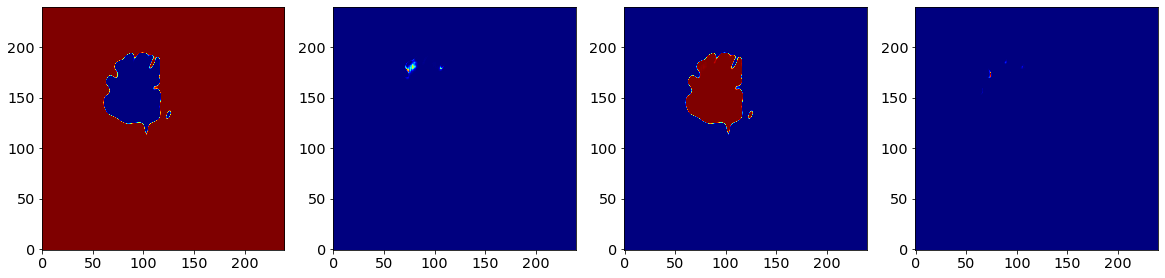

In [491]:
vu.show_n_images([pred_stats[100,:,:,i] for i in range(4)])

In [492]:
pred = prediction_from_probabily_3D(pred_stats)
pred.shape,np.unique(pred)

((155, 240, 240), array([0, 1, 2, 3]))

In [493]:
np.unique(pred)

array([0, 1, 2, 3])

<Figure size 432x360 with 0 Axes>

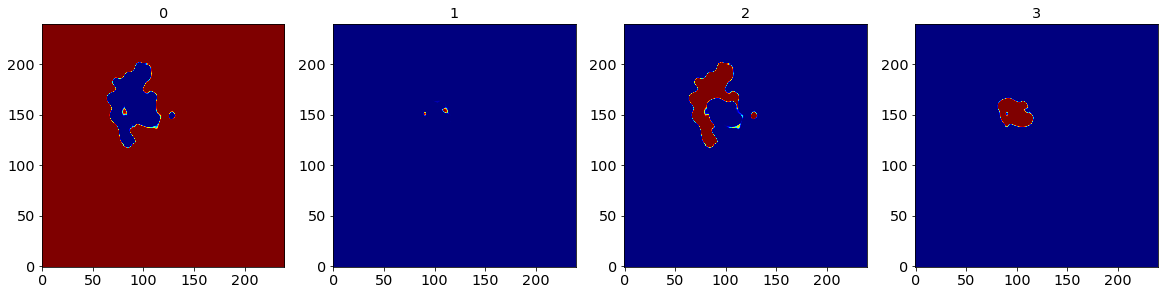

In [494]:
i=70
vu.show_n_images([pred_stats[i,:,:,0],pred_stats[i,:,:,1],pred_stats[i,:,:,2],pred_stats[i,:,:,3]],
                titles=[0,1,2,3])

View predicted probabilities, and the resulted labels

<Figure size 432x360 with 0 Axes>

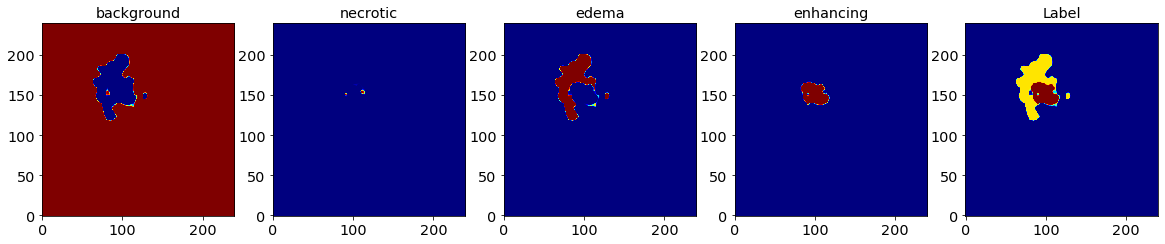

<Figure size 432x360 with 0 Axes>

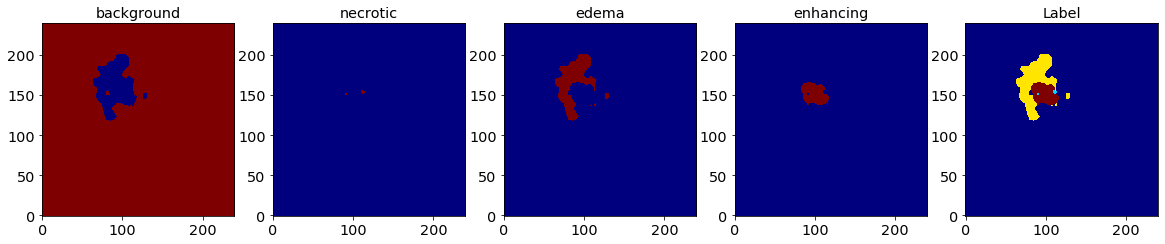

<Figure size 432x360 with 0 Axes>

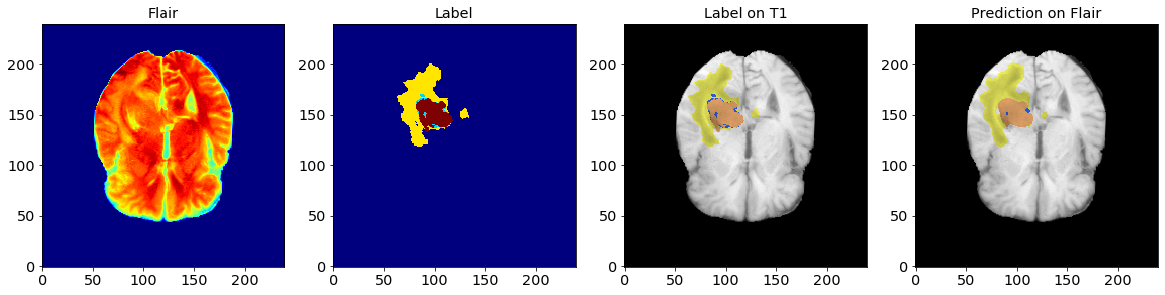

<Figure size 432x360 with 0 Axes>

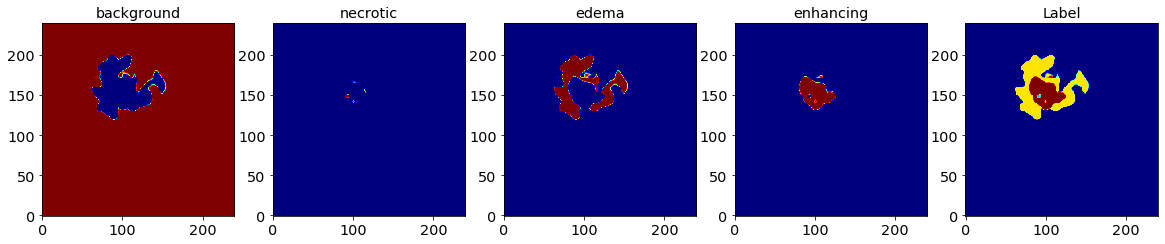

<Figure size 432x360 with 0 Axes>

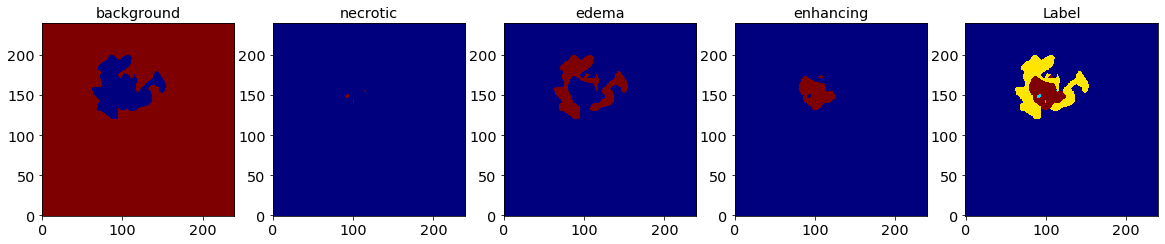

<Figure size 432x360 with 0 Axes>

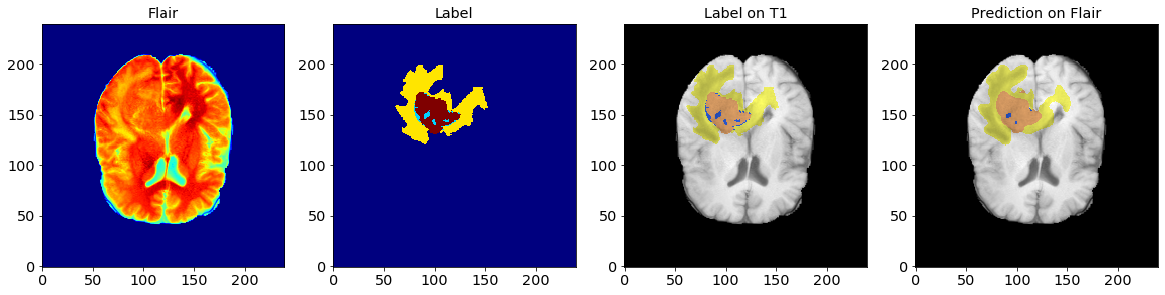

<Figure size 432x360 with 0 Axes>

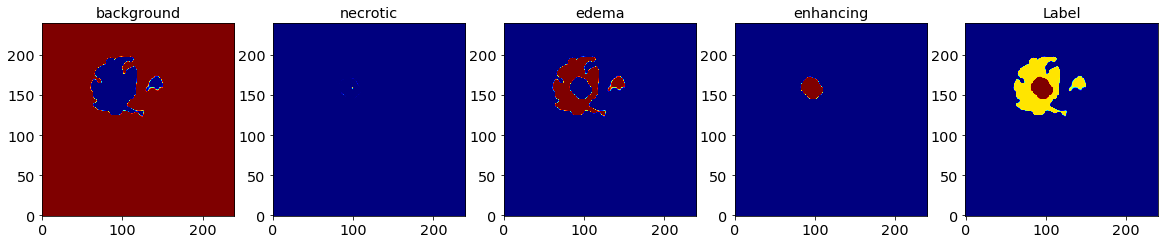

<Figure size 432x360 with 0 Axes>

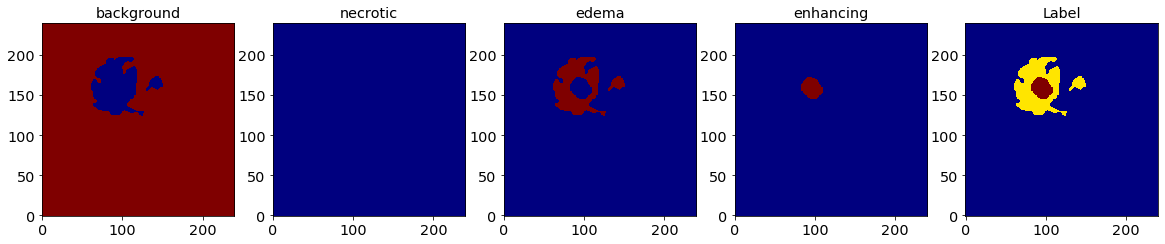

<Figure size 432x360 with 0 Axes>

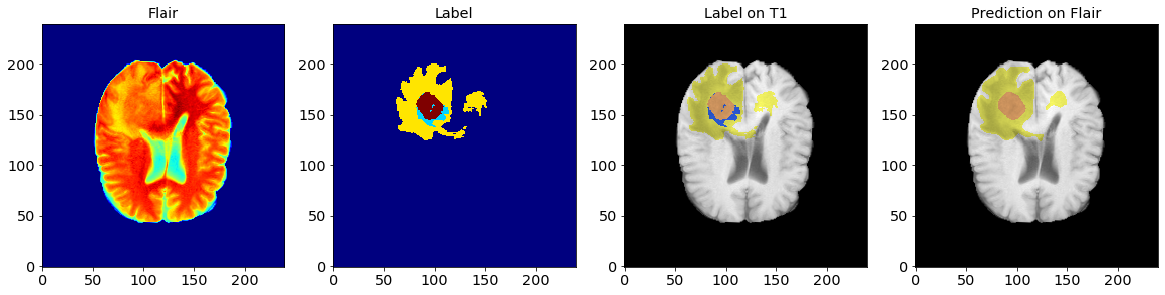

In [495]:
ind=[70,80,90]
for i in ind:
    show_lable(pred_stats[i])
    show_lable(get_pred(pred_stats[i]))
    show_pred_im_lable(im[i], lb[i], pred[i])

## Predict all test images to calculate IOU

In [88]:
TEST_PRED_NUMPY_DIR = '/naomi/DATA/predictions/pred2/test/numpy_images/'
VALIDATION_PRED_NUMPY_DIR = '/naomi/DATA/predictions/pred2/validation/numpy_images/'
VALIDATION_PRED_NII_DIR = '/naomi/DATA/predictions/pred2/validation/nii2/'

Check that its all working -:)

In [496]:
img_id = 'BraTS19_2013_18_1'
im,lb = get_numpy_img_lbl(img_id = 'BraTS19_2013_18_1')
im.shape,lb.shape

nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
pred_stats = predict_3D_img_prob(nimg)
pred_stats.shape

pred = prediction_from_probabily_3D(pred_stats)
pred.shape

(155, 240, 240)

<Figure size 432x360 with 0 Axes>

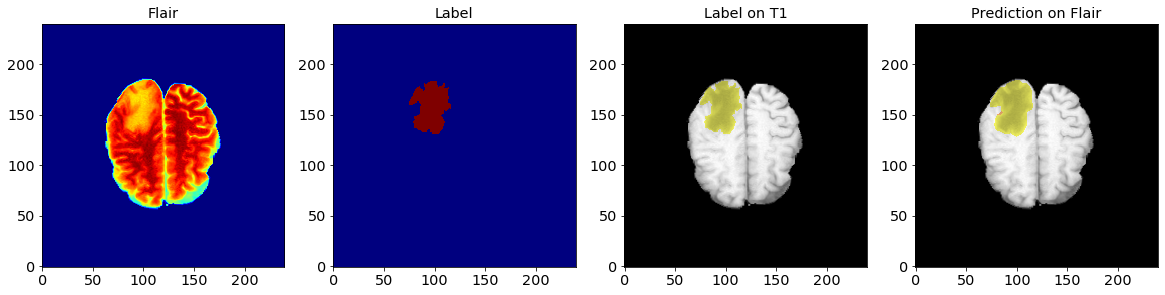

In [498]:
show_pred_im_lable(im[120], lb[120], pred[120])

In [225]:
TEST_PRED_NUMPY_DIR='/naomi/DATA/predictions/pred2/test/numpy_images/'

In [500]:
for index, row in df_test.iterrows():

    img_id = row['id']
    im,lb = get_numpy_img_lbl(img_id)

    nimg = os.path.join(NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')

    np.save(out_img, pred)
    print('Saving: ', out_img)

Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_TCIA03_257_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_CBICA_AQT_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_TCIA01_499_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_CBICA_BFB_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_CBICA_AOC_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_TCIA05_277_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_CBICA_ATF_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_CBICA_ALX_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_TCIA06_409_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_CBICA_AAP_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy_images/BraTS19_TCIA02_394_1_pred.npy
Saving:  /naomi/DATA/predictions/pred2/test/numpy

In [514]:
img_id='BraTS19_2013_21_1'
im,lb = get_numpy_img_lbl(img_id)
out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')
pred = np.load(out_img)

<Figure size 432x360 with 0 Axes>

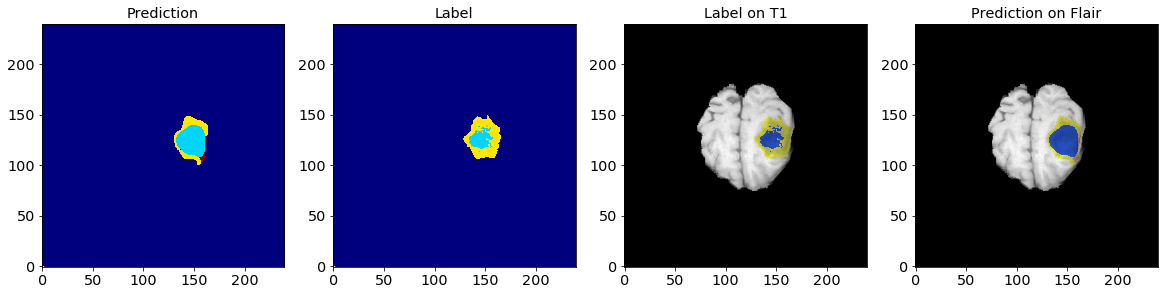

In [517]:
show_pred_im_lable(im[120], lb[120], pred[120])

<Figure size 432x360 with 0 Axes>

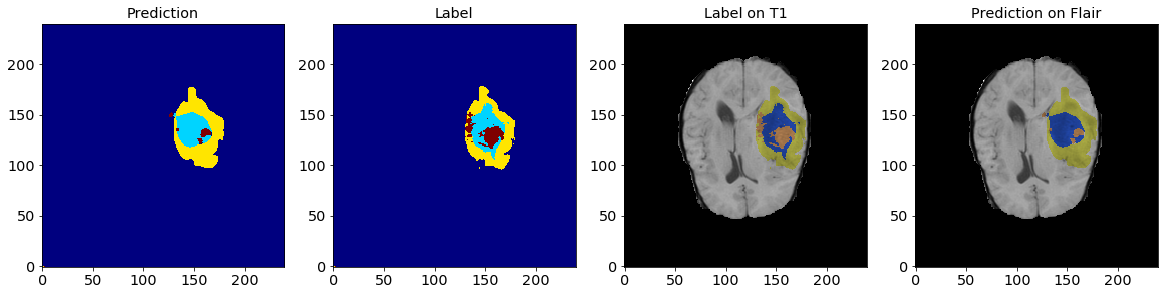

<Figure size 432x360 with 0 Axes>

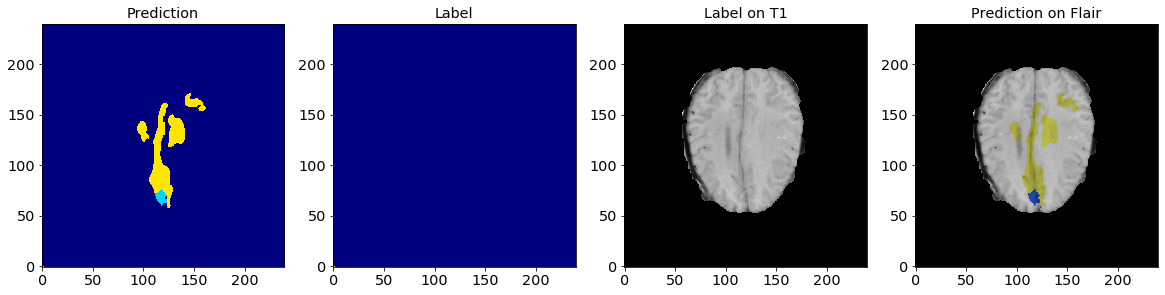

In [520]:
img_id='BraTS19_TCIA10_241_1'
im1,lb1 = get_numpy_img_lbl(img_id)
out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')
pred1 = np.load(out_img)
show_pred_im_lable(im1[80], lb1[80], pred1[80])
show_pred_im_lable(im1[100], lb1[100], pred1[100])

<Figure size 432x360 with 0 Axes>

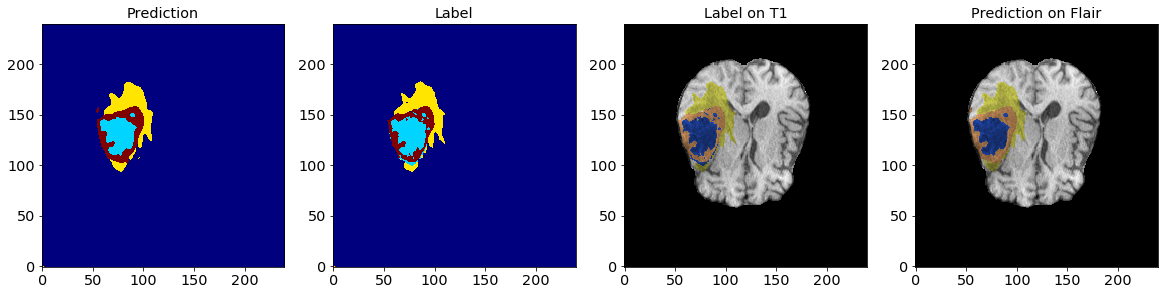

<Figure size 432x360 with 0 Axes>

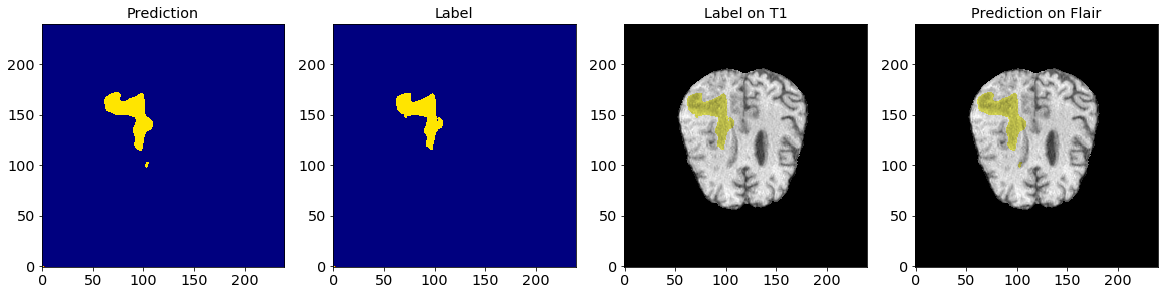

<Figure size 432x360 with 0 Axes>

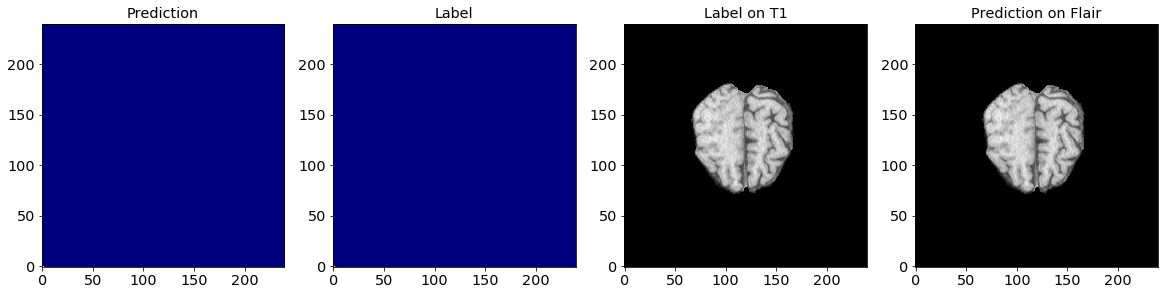

In [522]:
img_id='BraTS19_CBICA_AVF_1'
im1,lb1 = get_numpy_img_lbl(img_id)
out_img = os.path.join(TEST_PRED_NUMPY_DIR, img_id+'_pred.npy')
pred1 = np.load(out_img)
show_pred_im_lable(im1[80], lb1[80], pred1[80])
show_pred_im_lable(im1[100], lb1[100], pred1[100])
show_pred_im_lable(im1[120], lb1[120], pred1[120])

In [523]:
im, lb = get_df_img_batch(df_test.iloc[0:20])


In [525]:
pred = parallel_model.predict(im)

In [526]:
predl = prediction_from_probabily_3D(pred)

In [532]:
im.shape, lb.shape, pred.shape, predl.shape

((1344, 240, 240, 4),
 (1344, 240, 240, 4),
 (1344, 240, 240, 4),
 (1344, 240, 240))

In [535]:
lbl = get_label_from_pred_batch(lb)
lbl.shape

(1344, 240, 240)

In [548]:
lblc = pred_from_categorical(lb)
lblc.shape

(1344, 240, 240)

<Figure size 432x360 with 0 Axes>

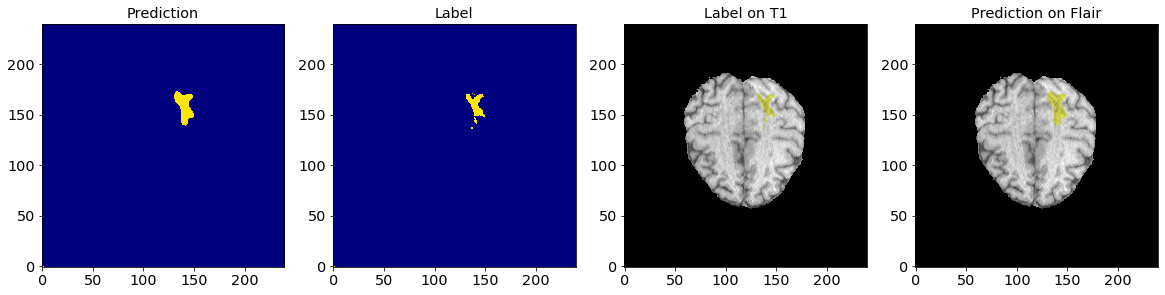

In [549]:
i=500
show_pred_im_lable(im[i], lblc[i], predl[i])

In [550]:
np.unique(lblc[i]), np.unique(predl[i])

(array([0, 1, 2, 3], dtype=uint8), array([0, 1, 2, 3]))

In [540]:
keras.metrics.accuracy(lb,pred)

<tf.Tensor 'Cast_1:0' shape=(1344, 240, 240, 4) dtype=float32>

In [542]:
dice_coef_loss(lb.astype(np.float32),pred)

<tf.Tensor 'Neg:0' shape=() dtype=float32>

In [501]:
df_test.shape, df_train.shape

((44, 14), (348, 26))

In [551]:
from sklearn.metrics import accuracy_score
accuracy_score(lblc.flatten(),predl.flatten())

0.9911020301132606

In [553]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(lblc.flatten(),predl.flatten())

In [562]:
cm

array([[75072453,    29296,   192013,    18086],
       [   19780,   170616,    30884,    29017],
       [  183981,    58306,  1079731,    27700],
       [   37723,    39092,    22953,   402769]])

In [556]:
!pip install seaborn

     |████████████████████████████████| 215kB 664kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [585]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (15,15), fontsize=8):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels())#, rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [586]:
labels = ['0','1','2','3']
cmdf=pd.DataFrame(cm, index=labels, columns=labels)
cmdf

,0,1,2,3
0,75072453,29296,192013,18086
1,19780,170616,30884,29017
2,183981,58306,1079731,27700
3,37723,39092,22953,402769


In [588]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmdfn=pd.DataFrame(cmn, index=labels, columns=labels)
cmdfn

,0,1,2,3
0,0.996821,0.000389,0.002550,0.000240
1,0.079026,0.681654,0.123389,0.115930
2,0.136311,0.043199,0.799968,0.020523
3,0.075065,0.077789,0.045674,0.801471


In [581]:
labels = ['0','1','2','3']
for colname, th in th_dict.items():
    cm = confusion_matrix(y_true=radar['Type'], 
                          y_pred=radar[colname], 
                          labels=labels)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    print ("Threshold:", th, '\n',colname,"\n--------------")
    #print( cm, '\n')
    print_confusion_matrix(cm, labels)
    plt.show()

NameError: name 'th_dict' is not defined

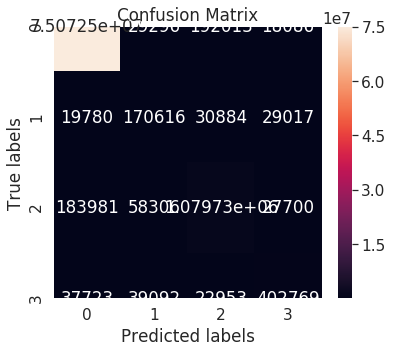

In [564]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g',ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0','1','2','3']); ax.yaxis.set_ticklabels(['0','1','2','3']);

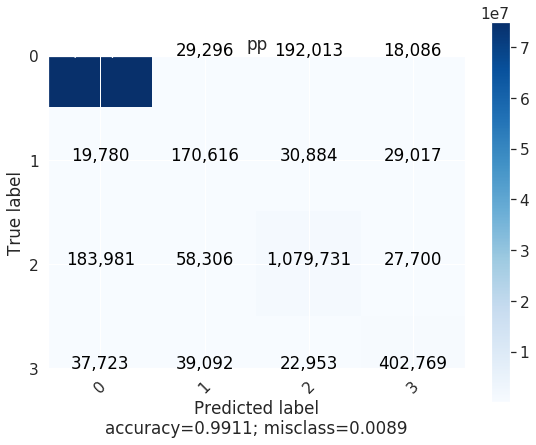

In [572]:
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    
    cmap = plt.get_cmap('Blues')
    normalize = False
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('pp')
    plt.colorbar()

    target_names=['0','1','2','3']
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

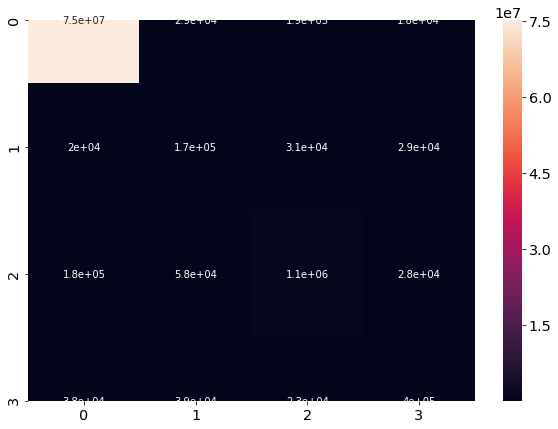

In [557]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index = [i for i in "0123"],
                  columns = [i for i in "0123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

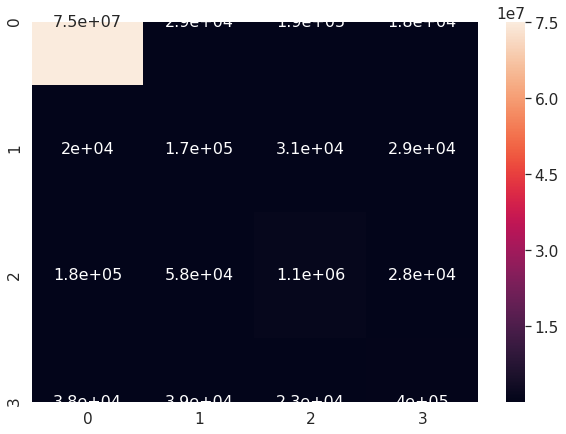

In [560]:
df_cm = pd.DataFrame(cm, range(4),
                  range(4))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

plt.show()

In [579]:
lb.shape, pred.shape,lb[:,:,:, 0].shape

((1344, 240, 240, 4), (1344, 240, 240, 4), (1344, 240, 240))

In [593]:
from sklearn.metrics import roc_curve
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
l=lb.reshape(1344*240*240,4)
p=pred.reshape(1344*240*240,4)
for i in range(4):
    print(l[:,i].shape,p[:,i].shape)
    fpr[i], tpr[i], _ = roc_curve(l[:,i],p[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

(77414400,) (77414400,)


ValueError: multiclass format is not supported

## Predict all validation image

In [92]:
df_val.head()

,id,lab0,lab1,lab2,lab3
0,BraTS19_TCIA09_381_1,0,0,0,0
1,BraTS19_TCIA01_341_1,0,0,0,0
2,BraTS19_TCIA10_236_1,0,0,0,0
3,BraTS19_TCIA05_484_1,0,0,0,0
4,BraTS19_MDA_922_1,0,0,0,0


In [216]:
VALIDATION_NUMPY_DIR

'/naomi/DATA/MICCAI_BraTS_2019_Data_Validation/numpy_images/'

In [217]:
VALIDATION_PRED_NII_DIR='/naomi/DATA/predictions/pred2/validation/nii2/'

In [218]:
VALIDATION_PRED_NII_DIR

'/naomi/DATA/predictions/pred2/validation/nii2/'

In [219]:
VALIDATION_PRED_NUMPY_DIR = 'DATA/predictions/pred2/validation/numpy_images/'

<Figure size 432x360 with 0 Axes>

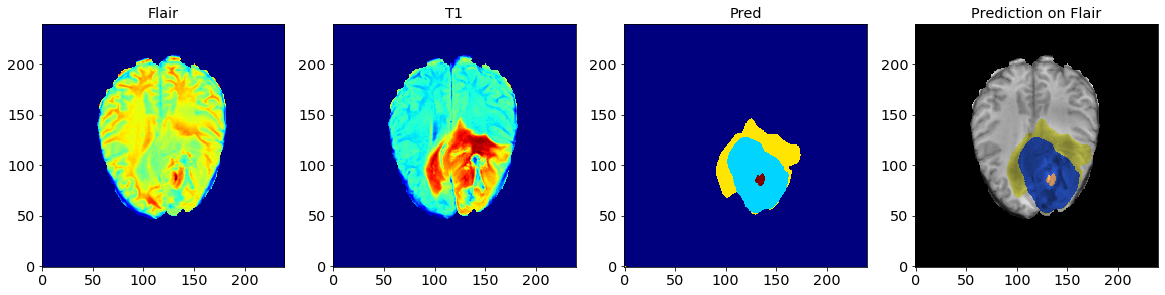

In [510]:
img_id='BraTS19_TCIA13_616_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[100], pred[100])

<Figure size 432x360 with 0 Axes>

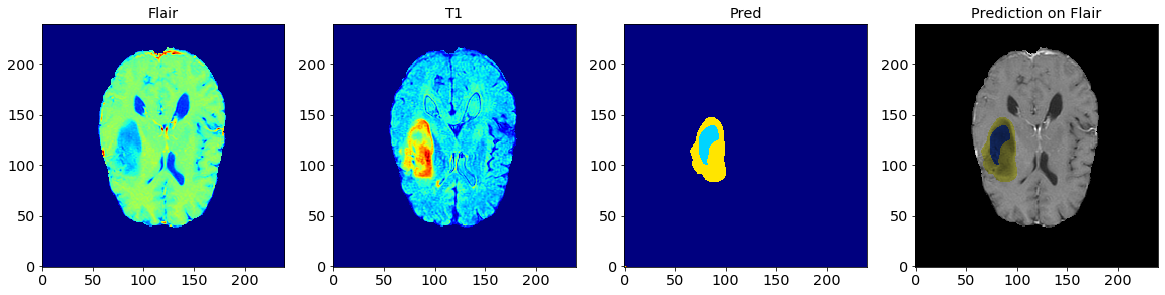

In [511]:
img_id='BraTS19_TCIA10_236_1'
nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
im = np.load(nimg)
pred_stats = predict_3D_img_prob(nimg)
pred = prediction_from_probabily_3D(pred_stats)
show_pred_im(im[80], pred[80])

In [505]:
 np.unique(pred[80])

array([0, 1, 2])

In [512]:
for index, row in df_val.iterrows():

    img_id = row['id']

    nimg = os.path.join(VALIDATION_NUMPY_DIR, img_id+'.npy')
    pred_stats = predict_3D_img_prob(nimg)

    pred = prediction_from_probabily_3D(pred_stats)

    out_img = os.path.join(VALIDATION_PRED_NUMPY_DIR, img_id+'_pred.npy')
    np.save(out_img, pred)
    
    pred = np.where(pred==3,4, pred)
    out_nii = os.path.join(VALIDATION_PRED_NII_DIR, img_id+'.nii.gz')

    sitk_img = sitk.GetImageFromArray(pred)
    sitk.WriteImage(sitk_img , out_nii)
    
    print('Saving: ', out_nii)

Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA09_381_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA01_341_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA10_236_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA05_484_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_MDA_922_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA10_647_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA13_619_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_MDA_1015_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA02_210_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_CBICA_BHN_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA03_313_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA13_622_1.nii.gz
Saving:  /

Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_WashU_W038_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_UAB_3456_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_WashU_S040_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_CBICA_AMF_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_MDA_1081_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA05_456_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA13_617_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA04_212_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA12_613_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_UAB_3448_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA10_467_1.nii.gz
Saving:  /naomi/DATA/predictions/pred2/validation/nii2/BraTS19_TCIA09_385_1.nii.gz
Saving:  /n